In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import imageio
import scipy
import pandas as pd
from functools import partial

GPU = -1
use_mixed_prec = False

physical_gpus = tf.config.list_physical_devices('GPU')
if physical_gpus:
    try:
        if GPU != "both":
            if GPU == 0:
                os.environ["CUDA_VISIBLE_DEVICES"] = "0"
                # Disable GPU
                tf.config.set_visible_devices(physical_gpus[GPU], 'GPU')
            elif GPU == 1:
                os.environ["CUDA_VISIBLE_DEVICES"] = "1"
                # Disable GPU
                tf.config.set_visible_devices(physical_gpus[GPU], 'GPU')
            if GPU == -1:
                os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
                # Disable GPU
                tf.config.set_visible_devices([], 'GPU')
        visible_gpus = tf.config.get_visible_devices('GPU')
        print("Num Visible Physical GPUs: ", len(physical_gpus),
              "\nNum Visible GPUs Available: ", len(visible_gpus))
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(visible_gpus), "Visible GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)
        
%matplotlib inline
%load_ext autoreload
%autoreload 2
MAP_AUTOTUNE = int(os.cpu_count()*3/4)#tf.data.AUTOTUNE#os.cpu_count()#int(os.cpu_count()*3/4)
AUTOTUNE = tf.data.AUTOTUNE
print('Tensorflow version: ' + tf.__version__)
os.environ['NO_GCE_CHECK'] = 'true'

# For Mixed Precision
from tensorflow.keras import mixed_precision
if use_mixed_prec:
    mixed_precision.set_global_policy('mixed_float16')

Num Visible Physical GPUs:  2 
Num Visible GPUs Available:  0
0 Visible GPUs, 0 Logical GPUs
Tensorflow version: 2.8.0


In [7]:
import imageio
import os
import numpy
from collections.abc import Iterable

def load_image(path):
    # Load Image
    if path.endswith('.npy'):
        img = np.load(path)
    else:
        img = imageio.imread(path)
    return img

def get_jpeg_q_compression_rel(data_dir, output_dir, q_factors):
    file_list = [file for file in os.listdir(data_dir)
                 if os.path.isfile(os.path.join(data_dir, file))]
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    if not isinstance(q_factors, Iterable):
        q_factors = [q_factors]
    total_stats = []
    for quality_factor in q_factors:
        out_dir = os.path.join(output_dir, f"{output_dir}_Q{quality_factor}")
        if not os.path.exists(out_dir):
            os.mkdir(out_dir)
        file_stats = {"filenames": file_list, 
                      "quality_factor": quality_factor,
                      "output_dir": out_dir,
                      "orig_file_sizes": [],
                      "comp_file_sizes": []}
        for file in file_list:
            in_path = os.path.join(data_dir, file)
            file_stats["orig_file_sizes"].append(os.stat(in_path).st_size)
            img = load_image(in_path)
            new_filename = os.path.splitext(file)[0] + ".jpg"
            out_path = os.path.join(out_dir, new_filename)
            imageio.imsave(out_path, img, quality=quality_factor)
            file_stats["comp_file_sizes"].append(os.stat(out_path).st_size)
        total_stats.append(file_stats)
    return total_stats

In [8]:
DATA_DIR = "raw_data"
OUTPUT_DIR = "jpg_compressed"
Q_FACTORS = [10, 20, 30, 50, 70, 100]
total_stats = get_jpeg_q_compression_rel(DATA_DIR, OUTPUT_DIR, Q_FACTORS)

In [12]:
total_stats[-1]["quality_factor"]

100

In [89]:
q = []
comp_ratios = []
comp_ratio_errs = []
for stat in total_stats:
    q_factor = stat["quality_factor"]
    avg_orig_size = np.mean(stat["orig_file_sizes"])
    orig_size_std = np.std(stat["orig_file_sizes"])
    avg_comp_size = np.mean(stat["comp_file_sizes"])
    comp_size_std = np.std(stat["comp_file_sizes"])
    avg_compression_ratio = avg_orig_size/avg_comp_size
    avg_comp_ratio_err = np.sqrt((orig_size_std/avg_orig_size)**2 + (comp_size_std/avg_comp_size)**2)
    print("##############################")
    print(f"Q = {q_factor}")
    print(f"comp_ratio = {avg_compression_ratio} +/- {avg_comp_ratio_err}")
    q.append(q_factor)
    comp_ratios.append(avg_compression_ratio)
    comp_ratio_errs.append(avg_comp_ratio_err)

##############################
Q = 10
comp_ratio = 40.48492635332773 +/- 0.3897893401413034
##############################
Q = 20
comp_ratio = 26.597314300255835 +/- 0.4216548598934686
##############################
Q = 30
comp_ratio = 20.67580110666092 +/- 0.4315259649638593
##############################
Q = 50
comp_ratio = 15.123000591029314 +/- 0.43577289001169317
##############################
Q = 70
comp_ratio = 11.07937920310342 +/- 0.4325696717741948
##############################
Q = 100
comp_ratio = 1.9658443059524595 +/- 0.32856025836033


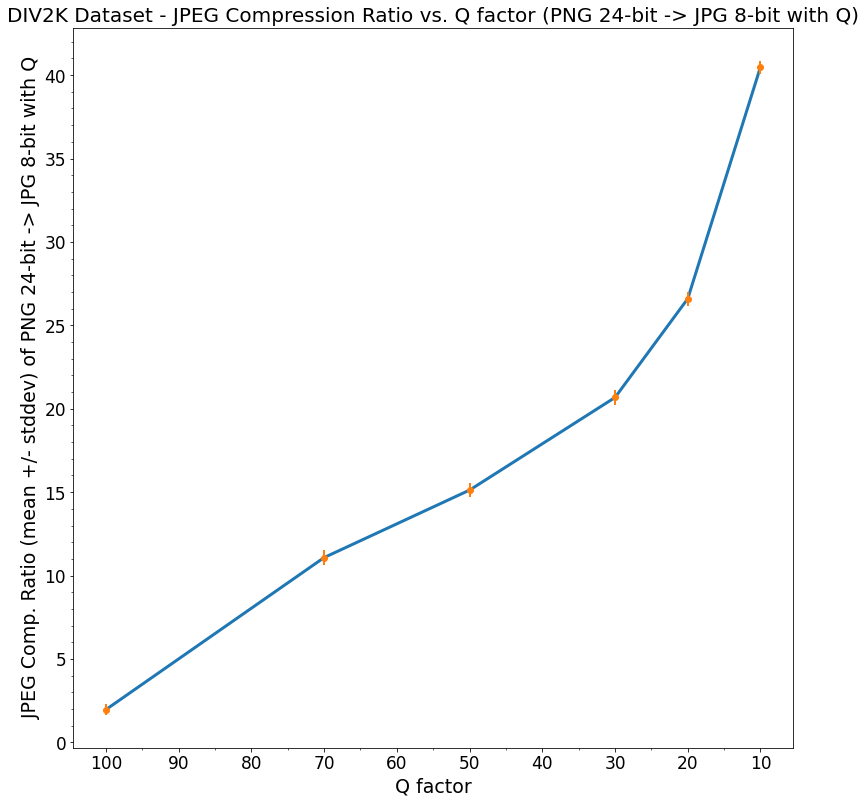

In [91]:
import matplotlib.ticker as ticker
figsize = (10, 10)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.tick_params(axis='both', labelsize=17)
plt.plot(q, comp_ratios, linewidth=3)
plt.errorbar(q, comp_ratios, yerr = comp_ratio_errs, fmt ='o', linewidth=2)
plt.xlabel("Q factor", fontsize=19)
plt.ylabel("JPEG Comp. Ratio (mean +/- stddev) of PNG 24-bit -> JPG 8-bit with Q", fontsize=19)
plt.title("DIV2K Dataset - JPEG Compression Ratio vs. Q factor (PNG 24-bit -> JPG 8-bit with Q)", fontsize=20)
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(5))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(1))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(5))
plt.gca().invert_xaxis()
plt.show()

In [85]:
avg_size_q100 = np.mean(total_stats[-1]["comp_file_sizes"])
size_q100_std = np.std(total_stats[-1]["comp_file_sizes"])
q = []
comp_ratios = []
comp_ratio_errs = []
for stat in total_stats:
    q_factor = stat["quality_factor"]
    avg_comp_size = np.mean(stat["comp_file_sizes"])
    comp_size_std = np.std(stat["comp_file_sizes"])
    avg_compression_ratio = avg_size_q100/avg_comp_size
    avg_comp_ratio_err = np.sqrt((size_q100_std/avg_size_q100)**2 + (comp_size_std/avg_comp_size)**2)
    print("##############################")
    print(f"Q = {q_factor}")
    print(f"comp_ratio = {avg_compression_ratio} +/- {avg_comp_ratio_err}")
    q.append(q_factor)
    comp_ratios.append(avg_compression_ratio)
    comp_ratio_errs.append(avg_comp_ratio_err)

##############################
Q = 10
comp_ratio = 20.59416721392522 +/- 0.3996552775741899
##############################
Q = 20
comp_ratio = 13.52971556278427 +/- 0.4307916341770006
##############################
Q = 30
comp_ratio = 10.517517101459065 +/- 0.44045802256639627
##############################
Q = 50
comp_ratio = 7.6928780907204946 +/- 0.44461963842620955
##############################
Q = 70
comp_ratio = 5.635939310939182 +/- 0.44148061355391893
##############################
Q = 100
comp_ratio = 1.0 +/- 0.34020648814935445


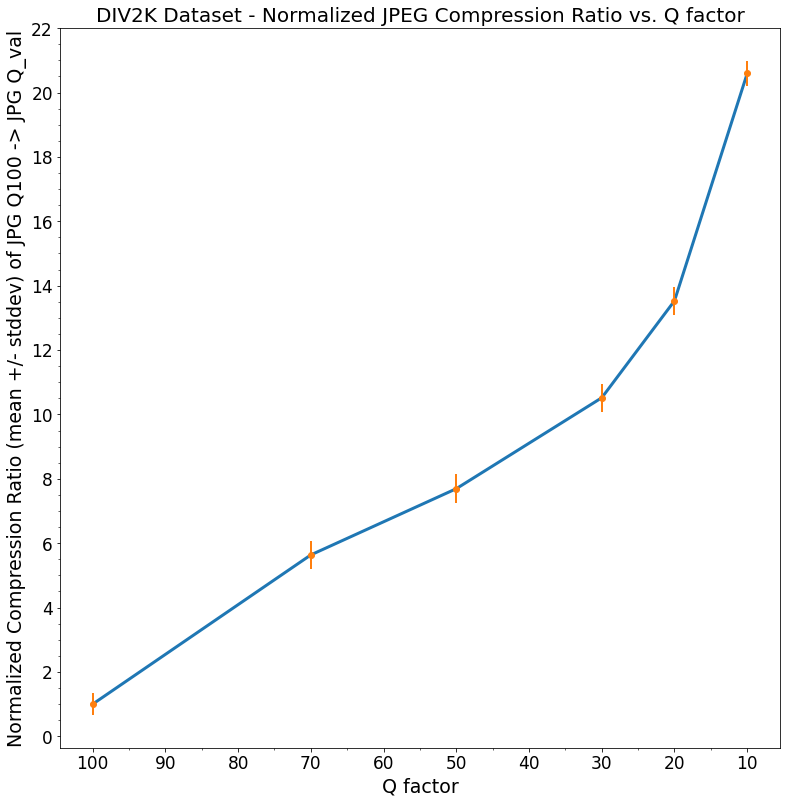

In [88]:
figsize = (10, 10)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.tick_params(axis='both', labelsize=17)
plt.plot(q, comp_ratios, linewidth=3)
plt.errorbar(q, comp_ratios, yerr = comp_ratio_errs, fmt ='o', linewidth=2)
plt.xlabel("Q factor", fontsize=19)
plt.ylabel("Normalized Compression Ratio (mean +/- stddev) of JPG Q100 -> JPG Q_val", fontsize=19)
plt.title("DIV2K Dataset - Normalized JPEG Compression Ratio vs. Q factor", fontsize=20)
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(5))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.5))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(2))
plt.gca().invert_xaxis()
plt.show()